# 2-4-1 Textual Inversion

[An Image is Worth One Word: Personalizing Text-to-Image Generation using Textual Inversion](http://arxiv.org/abs/2208.01618)

## 0 章节目标

* 理解 Textural Inversion 的基本思想
* 学习如何使用 Huggingface 的代码微调自己的模型

## 1 问题背景

Textual Inversion 仅需要用户提供 3~5 张含有某个特定概念 $S^*$ 的图片（既可以是某个主体，也可以是某种风格），就可以结合扩散模型的先验知识进行创作，将这个新的概念 $S^*$ 融合进生成的图片中。

![](https://textual-inversion.github.io/static/images/editing/teaser.JPG)

在大模型中引入新的概念通常是很困难的：对每一个新概念 Fine tuning 整个模型成本太高，且当新概念的示例个数较少时，Fine tuning 会面临灾难性遗忘的问题。一种改进的办法是冻结大模型本身，并训练一个 Adapter，但这并不能完全解决灾难性遗忘，且难以同时处理新学习的概念与原始先验同时出现的情形。

Textual Inversion 旨在为新的概念学习一个新的 embedding。如此一来，这个新概念可以被视为一个伪词（pseudo-word），它在生成过程中与其他一般的单词扮演相同的角色。这么做的一个好处是，Textual Inversion 的微调没有修改生成模型本身，因此模型不会失去丰富的文本理解和泛化能力。

## 2 微调方法

Textural Inversion 的实现建立在 Latent Diffusion Models（[LDM](https://arxiv.org/abs/2112.10752)）之上，其包括两个部分：自编码器和扩散模型。自编码器的 Encoder 将 $x$ 映射为隐空间中的 $z=\mathcal{E}(x)$，而 Decoder 将其映射回原空间：$D(\mathcal{E})\approx x$。自编码器事先通过 KL 散度或矢量量化的方法预训练好，随后在扩散模型中，就从隐空间的 $z_t$ 开始对图形进行去噪重建。因此，目标函数由：
$$
L_{DM}=\mathbb{E}_{x,\epsilon \sim \mathcal{N}\left( 0,1 \right) ,t}\left[ \lVert \epsilon -\epsilon _{\theta}\left( x,t \right) \rVert _{2}^{2} \right] 
$$
变为：
$$
L_{LDM}:=\mathbb{E}_{z\sim \mathcal{E}\left( x \right) ,\epsilon \sim \mathcal{N}\left( 0,1 \right) ,t}\left[ \lVert \epsilon -\epsilon _{\theta}\left( z_t,t \right) \rVert _{2}^{2} \right] 
$$
![](https://ommer-lab.com/wp-content/uploads/2022/08/article-Figure3-1-1536x762.png)
接下来引入条件机制，LDM的目标函数即：
$$
L_{LDM}:=\mathbb{E}_{z\sim \mathcal{E}\left( x \right) ,y,\epsilon \sim \mathcal{N}\left( 0,1 \right) ,t}\left[ \lVert \epsilon -\epsilon _{\theta}\left( z_t,t,c_{\theta}\left( y \right) \right) \rVert _{2}^{2} \right] 
$$
Textual Inversion 为要学习的新概念设置了一个占位符 $S^*$，并干预 Encoder 计算嵌入的过程，学习得到嵌入向量 $v^∗$ 来替换与标记化字符串相关联的向量。通过这一方式，Textual Inversion 将新概念“注入”到了模型原有的词汇表中。

而为了学习这一嵌入向量 $v^*$，Textual Inversion 使用一个小型的图像集（通常为3~5张），用不同的 prompt 描述目标概念，通过最小化条件 LDM 扩散模型目标函数 $L_{LDM}$ 来找到 $v^∗$。这些 prompt 随机采样自 CLIP ImageNet 模板。

![](https://textual-inversion.github.io/static/images/training/training.JPG)

## 3 实验结果

![](https://textual-inversion.github.io/static/images/editing/bowl.JPG)
实验结果表明，Textual Inversion 相比普通的图像生成模型（如 DALL·E-2，LDM），可以更好地捕捉新概念的独特细节（如碗的色调、花纹），同时保留模型本身的先验（如保留了“碗可以盛放其他物体”的先验知识）。它与先前的一些模型（如 PALAVRA）不一样的地方在于，PALAVRA 等模型只学到了用来区分两种概念的特征，而 Textual Inversion 则能够生成这些独特的特征。

同时 Textural Inversion 具备风格迁移的能力，这意味着待学习的新概念不局限于一个具体的主体概念，也可以是某种抽象的概念。在这一点上，其很接近的研究 DreamBooth 似乎并不具备（*待验证*）。而且由于 Textural Inversion 的方案中，新概念在隐空间中就相当于一个普通的 token，所以可以同时对多个概念进行微调，在一个 prompt 内可以包括多个新的概念（DreamBooth 同样具备这种特点，对于这种类型的方案，在多个概念上分别微调模型似乎不会影响已经微调好的概念的生成效果）。

Textural Inversion 的这种方案不仅可以引入新的概念，同样也可以对已有概念进行修正，例如减少大模型本身具有的偏见。这可能也可被用来消除大模型对某一个概念的先验（[DA_Fusion](http://arxiv.org/abs/2302.07944)）。
![](https://textual-inversion.github.io/static/images/bias/bias.JPG)

更多实验结果请参考原论文和官方网站：[https://textual-inversion.github.io/](https://textual-inversion.github.io/)，

## 4 局限性
Textural Inversion 并不能很好地控制生成的新主体的形状，这也是因为，它并不是单纯地将新的主体“合成”进图片中。

此外，Textural Inversion 的微调时间很长。据论文作者称，学习一个新的概念大约需要两小时（2 x V100）。相比之下，DreamBooth 半个小时内就搞定了（1 x A100-PCIE）。

## 5 训练与推理（TODO: 还没跑完）

In [17]:
import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

from constant import MODEL_PATH, DATA_PATH


def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

In [6]:
model_id = os.path.join(MODEL_PATH, "stable-diffusion-2-1")
image_dir = os.path.join(DATA_PATH, 'cat')

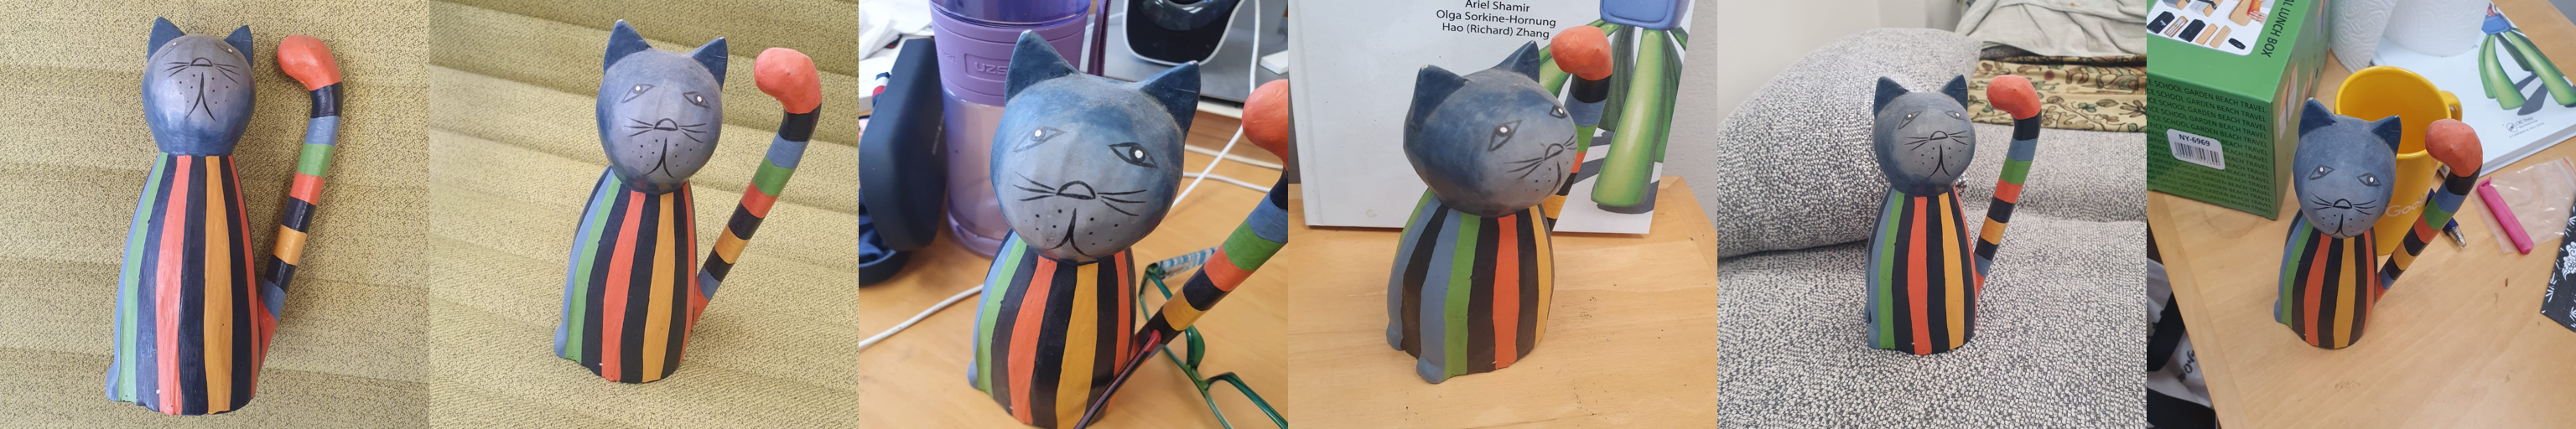

In [7]:
images = []
for file_path in os.listdir(image_dir):
    try:
        image_path = os.path.join(image_dir, file_path)
        images.append(Image.open(image_path).resize((512, 512)))
    except:
        print(
            f"{image_path} is not a valid image, please make sure to remove this file from the directory otherwise the training could fail.")
image_grid(images, 1, len(images))

In [8]:
what_to_teach = "object"
placeholder_token = "<cat-toy>"
initializer_token = "toy"

In [9]:
#@title Setup the prompt templates for training 
imagenet_templates_small = [
    "a photo of a {}",
    "a rendering of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a clean {}",
    "a photo of a dirty {}",
    "a dark photo of the {}",
    "a photo of my {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "a photo of the nice {}",
    "a photo of the small {}",
    "a photo of the weird {}",
    "a photo of the large {}",
    "a photo of a cool {}",
    "a photo of a small {}",
]

imagenet_style_templates_small = [
    "a painting in the style of {}",
    "a rendering in the style of {}",
    "a cropped painting in the style of {}",
    "the painting in the style of {}",
    "a clean painting in the style of {}",
    "a dirty painting in the style of {}",
    "a dark painting in the style of {}",
    "a picture in the style of {}",
    "a cool painting in the style of {}",
    "a close-up painting in the style of {}",
    "a bright painting in the style of {}",
    "a cropped painting in the style of {}",
    "a good painting in the style of {}",
    "a close-up painting in the style of {}",
    "a rendition in the style of {}",
    "a nice painting in the style of {}",
    "a small painting in the style of {}",
    "a weird painting in the style of {}",
    "a large painting in the style of {}",
]

In [10]:
#@title Setup the dataset
class TextualInversionDataset(Dataset):
    def __init__(
            self,
            data_root,
            tokenizer,
            learnable_property="object",  # [object, style]
            size=512,
            repeats=100,
            interpolation="bicubic",
            flip_p=0.5,
            set="train",
            placeholder_token="*",
            center_crop=False,
    ):

        self.data_root = data_root
        self.tokenizer = tokenizer
        self.learnable_property = learnable_property
        self.size = size
        self.placeholder_token = placeholder_token
        self.center_crop = center_crop
        self.flip_p = flip_p

        self.image_paths = [os.path.join(self.data_root, file_path) for file_path in os.listdir(self.data_root)]

        self.num_images = len(self.image_paths)
        self._length = self.num_images

        if set == "train":
            self._length = self.num_images * repeats

        self.interpolation = {
            "linear": PIL.Image.LINEAR,
            "bilinear": PIL.Image.BILINEAR,
            "bicubic": PIL.Image.BICUBIC,
            "lanczos": PIL.Image.LANCZOS,
        }[interpolation]

        self.templates = imagenet_style_templates_small if learnable_property == "style" else imagenet_templates_small
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}
        image = Image.open(self.image_paths[i % self.num_images])

        if not image.mode == "RGB":
            image = image.convert("RGB")

        placeholder_string = self.placeholder_token
        text = random.choice(self.templates).format(placeholder_string)

        example["input_ids"] = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids[0]

        # default to score-sde preprocessing
        img = np.array(image).astype(np.uint8)

        if self.center_crop:
            crop = min(img.shape[0], img.shape[1])
            h, w, = (
                img.shape[0],
                img.shape[1],
            )
            img = img[(h - crop) // 2: (h + crop) // 2, (w - crop) // 2: (w + crop) // 2]

        image = Image.fromarray(img)
        image = image.resize((self.size, self.size), resample=self.interpolation)

        image = self.flip_transform(image)
        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float32)

        example["pixel_values"] = torch.from_numpy(image).permute(2, 0, 1)
        return example

In [11]:
#@title Load the tokenizer and add the placeholder token as a additional special token.
tokenizer = CLIPTokenizer.from_pretrained(
    model_id,
    subfolder="tokenizer",
)

# Add the placeholder token in tokenizer
num_added_tokens = tokenizer.add_tokens(placeholder_token)
if num_added_tokens == 0:
    raise ValueError(
        f"The tokenizer already contains the token {placeholder_token}. Please pass a different"
        " `placeholder_token` that is not already in the tokenizer."
    )

In [12]:
#@title Get token ids for our placeholder and initializer token. This code block will complain if initializer string is not a single token
# Convert the initializer_token, placeholder_token to ids
token_ids = tokenizer.encode(initializer_token, add_special_tokens=False)
# Check if initializer_token is a single token or a sequence of tokens
if len(token_ids) > 1:
    raise ValueError("The initializer token must be a single token.")

initializer_token_id = token_ids[0]
placeholder_token_id = tokenizer.convert_tokens_to_ids(placeholder_token)

In [14]:
#@title Load the Stable Diffusion model
# Load models and create wrapper for stable diffusion
# pipeline = StableDiffusionPipeline.from_pretrained(pretrained_model_name_or_path)
# del pipeline
text_encoder = CLIPTextModel.from_pretrained(
    model_id, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    model_id, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    model_id, subfolder="unet"
)

In [15]:
text_encoder.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 49409. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(49409, 1024)

In [16]:
token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]

In [18]:
def freeze_params(params):
    for param in params:
        param.requires_grad = False


# Freeze vae and unet
freeze_params(vae.parameters())
freeze_params(unet.parameters())
# Freeze all parameters except for the token embeddings in text encoder
params_to_freeze = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)
freeze_params(params_to_freeze)

In [19]:
train_dataset = TextualInversionDataset(
    data_root=image_dir,
    tokenizer=tokenizer,
    size=vae.sample_size,
    placeholder_token=placeholder_token,
    repeats=100,
    learnable_property=what_to_teach,  #Option selected above between object and style
    center_crop=False,
    set="train",
)

C:\Users\16402\AppData\Local\Temp\ipykernel_23900\866225192.py:4: FutureWarning: Accessing config attribute `sample_size` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'sample_size' over 'AutoencoderKL's config object instead, e.g. 'unet.config.sample_size'.
  size=vae.sample_size,
C:\Users\16402\AppData\Local\Temp\ipykernel_23900\1949286269.py:34: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use BILINEAR or Resampling.BILINEAR instead.
  "linear": PIL.Image.LINEAR,


In [20]:
def create_dataloader(train_batch_size=1):
    return torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

In [21]:
noise_scheduler = DDPMScheduler.from_config(model_id, subfolder="scheduler")

D:\anaconda3\envs\pytorch113\lib\site-packages\diffusers\configuration_utils.py:239: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


In [23]:
#@title Setting up all training args
hyperparameters = {
    "learning_rate": 5e-04,
    "scale_lr": True,
    "max_train_steps": 2000,
    "save_steps": 250,
    "train_batch_size": 4,
    "gradient_accumulation_steps": 1,
    "gradient_checkpointing": True,
    "mixed_precision": "fp16",
    "seed": 42,
    "output_dir": "sd-concept-output"
}
!mkdir sd-concept-output

子目录或文件 sd-concept-output 已经存在。


In [24]:
#@title Training function
logger = get_logger(__name__)


def save_progress(text_encoder, placeholder_token_id, accelerator, save_path):
    logger.info("Saving embeddings")
    learned_embeds = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[placeholder_token_id]
    learned_embeds_dict = {placeholder_token: learned_embeds.detach().cpu()}
    torch.save(learned_embeds_dict, save_path)


def training_function(text_encoder, vae, unet):
    train_batch_size = hyperparameters["train_batch_size"]
    gradient_accumulation_steps = hyperparameters["gradient_accumulation_steps"]
    learning_rate = hyperparameters["learning_rate"]
    max_train_steps = hyperparameters["max_train_steps"]
    output_dir = hyperparameters["output_dir"]
    gradient_checkpointing = hyperparameters["gradient_checkpointing"]

    accelerator = Accelerator(
        gradient_accumulation_steps=gradient_accumulation_steps,
        mixed_precision=hyperparameters["mixed_precision"]
    )

    if gradient_checkpointing:
        text_encoder.gradient_checkpointing_enable()
        unet.enable_gradient_checkpointing()

    train_dataloader = create_dataloader(train_batch_size)

    if hyperparameters["scale_lr"]:
        learning_rate = (
                learning_rate * gradient_accumulation_steps * train_batch_size * accelerator.num_processes
        )

    # Initialize the optimizer
    optimizer = torch.optim.AdamW(
        text_encoder.get_input_embeddings().parameters(),  # only optimize the embeddings
        lr=learning_rate,
    )

    text_encoder, optimizer, train_dataloader = accelerator.prepare(
        text_encoder, optimizer, train_dataloader
    )

    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    # Move vae and unet to device
    vae.to(accelerator.device, dtype=weight_dtype)
    unet.to(accelerator.device, dtype=weight_dtype)

    # Keep vae in eval mode as we don't train it
    vae.eval()
    # Keep unet in train mode to enable gradient checkpointing
    unet.train()

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        text_encoder.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(text_encoder):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample().detach()
                latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states.to(weight_dtype)).sample

                # Get the target for loss depending on the prediction type
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                loss = F.mse_loss(noise_pred, target, reduction="none").mean([1, 2, 3]).mean()
                accelerator.backward(loss)

                # Zero out the gradients for all token embeddings except the newly added
                # embeddings for the concept, as we only want to optimize the concept embeddings
                if accelerator.num_processes > 1:
                    grads = text_encoder.module.get_input_embeddings().weight.grad
                else:
                    grads = text_encoder.get_input_embeddings().weight.grad
                # Get the index for tokens that we want to zero the grads for
                index_grads_to_zero = torch.arange(len(tokenizer)) != placeholder_token_id
                grads.data[index_grads_to_zero, :] = grads.data[index_grads_to_zero, :].fill_(0)

                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1
                if global_step % hyperparameters["save_steps"] == 0:
                    save_path = os.path.join(output_dir, f"learned_embeds-step-{global_step}.bin")
                    save_progress(text_encoder, placeholder_token_id, accelerator, save_path)

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= max_train_steps:
                break

        accelerator.wait_for_everyone()

    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline.from_pretrained(
            model_id,
            text_encoder=accelerator.unwrap_model(text_encoder),
            tokenizer=tokenizer,
            vae=vae,
            unet=unet,
        )
        pipeline.save_pretrained(output_dir)
        # Also save the newly trained embeddings
        save_path = os.path.join(output_dir, f"learned_embeds.bin")
        save_progress(text_encoder, placeholder_token_id, accelerator, save_path)

In [25]:
import accelerate

accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet))

for param in itertools.chain(unet.parameters(), text_encoder.parameters()):
    if param.grad is not None:
        del param.grad  # free some memory
    torch.cuda.empty_cache()

ValueError: You have to specify the number of GPUs you would like to use, add `num_processes=...` to your call.